In [ ]:
!apt-get -qq install fonts-nanum

'apt-get'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import matplotlib.font_manager as fm
import matplotlib.pylab as plb

# 샘플링 코드
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN

import os

#사이킷 런 라이브러리
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier

from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import make_scorer, f1_score
from sklearn.linear_model import LogisticRegression

import pickle
import numpy as np
import pandas as pd





mpl.style.use("seaborn-v0_8")
mpl.rcParams.update({"figure.constrained_layout.use": True})
sns.set_context("paper")
sns.set_palette("Set2")
sns.set_style("whitegrid")
plt.rcParams["axes.unicode_minus"] = False

#폰트 설치 및 지정
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) # 폰트 설정

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# 필요한 함수의 정의
def grid_serch(train_x, train_y, model, params):
    scorer = make_scorer(f1_score, average='weighted')
    grid_model = GridSearchCV(model,
                              params,
                              cv=StratifiedKFold(5,shuffle=True,random_state=42),
                              n_jobs=-1,
                              verbose=1,
                              scoring=scorer)
    grid_model.fit(train_x, train_y)
    return grid_model

def rand_search(train_x, train_y, model, params, n_iters):
    scorer = make_scorer(f1_score, average='weighted')
    rand_model = RandomizedSearchCV(model,
                                    params,
                                    cv=StratifiedKFold(5,shuffle=True,random_state=42),
                                    n_jobs=-1,
                                    n_iter=n_iters,
                                    verbose=1,
                                    scoring=scorer)
    rand_model.fit(train_x, train_y)
    return rand_model

def result(model, x_train, y_train, x_test, y_test):
    pred = model.predict(x_test)
    print("정확도",accuracy_score(pred, y_test))
    print("confusion_matrix",confusion_matrix(y_test, pred))
    print("classification_report")
    print(classification_report(y_test, pred))

def prc_rec_prob(test_x ,test_y ,model_, name_):
    precision = precision_score(test_y, model_.predict(test_x), pos_label=1)
    recall = recall_score(test_y, model_.predict(test_x), pos_label=1)
    accuracy = accuracy_score(test_y, model_.predict(test_x))

    print(f'{name_: <20}',end=" |")
    print(f'Precision: {precision:.2f}',end=" |")
    print(f'Recall: {recall:.2f}',end=" |")
    print(f'Accuracy: {accuracy:.2f}')

    return precision, recall, accuracy

In [ ]:
horse_run = pd.read_csv("z.project\horse_run_final.csv", index_col=0)

In [ ]:
horse_run

,착순,기수경력(년),마필연령,부담중량,조교사경력(년),출주번호,습도,외산,수,암,무게,무게 증감량,경주마통산1착비율,기수통산1착비율
0,1,9,3,55.0,27.0,9,0.18,False,False,False,311,-18,0.500000,0.135868
1,0,13,3,54.0,29.0,2,0.18,False,False,True,283,-6,0.000000,0.093869
2,0,18,4,55.0,27.0,3,0.18,False,True,False,271,-5,0.000000,0.156444
3,0,6,2,54.0,27.0,6,0.18,False,False,True,265,-8,0.000000,0.080102
4,0,27,3,53.0,32.0,1,0.18,False,False,True,265,-2,0.000000,0.105547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63288,0,11,4,51.0,19.0,10,0.03,False,False,False,504,6,0.125000,0.060915
63289,0,9,5,52.0,11.0,12,0.03,False,True,False,494,-9,0.150000,0.056047
63290,0,13,7,55.0,15.0,6,0.03,False,False,False,467,2,0.156250,0.063735
63291,0,33,7,55.0,15.0,6,0.03,False,False,False,467,2,0.156250,0.063735


### 라벨 불균형 해결하기

In [ ]:
# horse_run["착순"].value_counts()

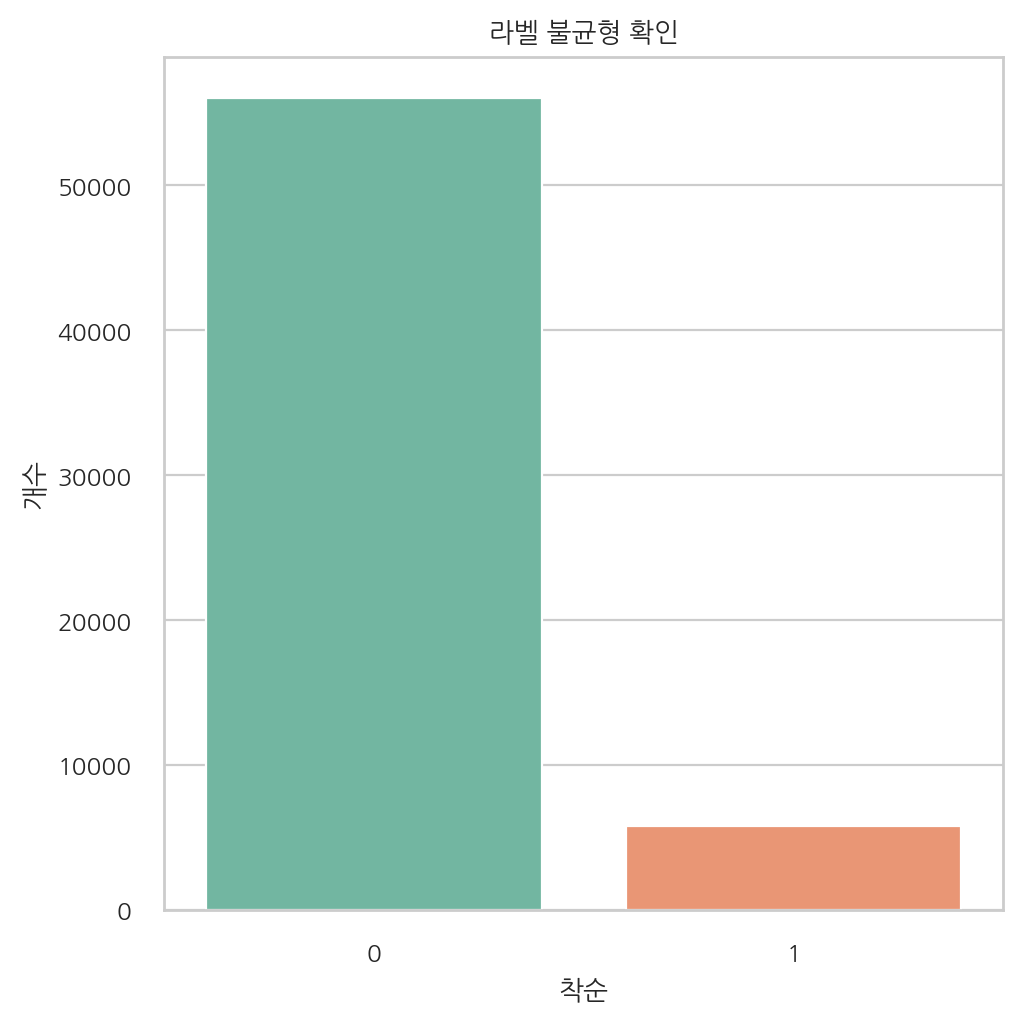

In [ ]:
# 착순 라벨의 불균형 확인
label_counts = horse_run["착순"].value_counts()
fig, ax = plt.subplots(figsize=(5, 5))
sns.barplot(x=label_counts.index, y=label_counts.values, ax=ax)
ax.set_title("라벨 불균형 확인")
ax.set_xlabel("착순")
ax.set_ylabel("개수")
plt.show()

In [ ]:
X = horse_run.drop("착순", axis=1)
y = horse_run["착순"]

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=0)

### 각 샘플링별 시행

In [ ]:
# 각 샘플링을 결과를 담을 dict 만들기
x_y_name = {}

# 랜덤 언더 샘플링
rus = RandomUnderSampler(random_state=0)
x_rus, y_rus = rus.fit_resample(train_x,train_y)

# ENN
enn = EditedNearestNeighbours(kind_sel="all", n_neighbors=5)
x_enn, y_enn = enn.fit_resample(train_x,train_y)

# RandomOver
ros = RandomOverSampler(random_state=0)
x_ros, y_ros = ros.fit_resample(train_x,train_y)

# SMOTE
smo = SMOTE(random_state=0)
x_smo, y_smo = smo.fit_resample(train_x,train_y)

# SMOENN
smoenn = SMOTEENN(random_state=0)
x_smoenn, y_smoenn = smoenn.fit_resample(train_x,train_y)

x_y_name["rus"] = x_rus, y_rus
x_y_name["enn"] = x_enn, y_enn
x_y_name["ros"] = x_ros, y_ros
x_y_name["smo"] = x_smo, y_smo
x_y_name["smoenn"] = x_smoenn, y_smoenn

In [ ]:
# 샘플링 후의 각 라벨 데이터의 비율
for x_y, name in zip(x_y_name.values(), x_y_name.keys()):
    print(f"{name} : {x_y[1].value_counts()[1] / (x_y[1].value_counts()[0] + x_y[1].value_counts()[1])}")

rus : 0.5
enn : 0.1418467702768334
ros : 0.5
smo : 0.5
smoenn : 0.6145125368201738


In [ ]:
result_csv = pd.DataFrame(columns=[
    '모델명',
    '하이퍼 파라미터',
    '샘플링 기법',
    '사용피쳐',
    'precision',
    'recall',
    'accuracy',
    'f1-score',
    'roc_auc 커브 면적'])
# result_csv.index = result_csv['모델명']
# result_csv.drop(columns=["모델명"], inplace=True)

### 샘플링 선택을 위해 기본 모델로 fit

In [ ]:
for key in x_y_name.keys():
    print(key,"샘플링의 각 결과")
    knn_rs = KNeighborsClassifier()
    dt_gs = DecisionTreeClassifier()
    rf_rs = RandomForestClassifier()
    ad_rs = AdaBoostClassifier()
    xg_rs = XGBClassifier()

    x__ , y__ = x_y_name[key][0], x_y_name[key][1]
    knn_rs.fit(x__,y__)
    dt_gs.fit(x__, y__)
    rf_rs.fit(x__, y__)
    ad_rs.fit(x__, y__)
    xg_rs.fit(x__, y__)

    models = [knn_rs, dt_gs, rf_rs, ad_rs, xg_rs]
    model_names = ['knn', 'decision Tree', 'random forest', 'ada boost', 'xg boost']

    for model, model_name in zip(models, model_names):
        with open(f'horse_models/{key}_{model_name}', 'wb') as f:
            pickle.dump(model, f)


    for model, name in zip(models, model_names):
        precision, recall, accuracy = prc_rec_prob(test_x, test_y, model, name)

        faces = roc_auc_score(test_y, model.predict_proba(test_x)[:,1])
        f1___ = 2 * (precision * recall) / (precision + recall)
        row = [f"{name}", 'default', f"{key}", 'All', precision, recall, accuracy, f1___ , faces]


        result_csv.loc[len(result_csv)] = row

    print("-" * 50)
    print("*" * 50)
    print("")

In [ ]:
# #필요 모델 불러오기

# with open(f'horse_models/ros_ada boost', 'rb') as f:
#     open_model = pickle.load(f)

### 샘플링 결정
- 각 샘플링 별 개별 모델의
    - precision, recall, accuracy를 보았을때 random over sampling이 적정하다고 판단되었다
    - random over sampling
        - random over sampling 의 랜덤 포레스트의 프리시전(0.48)이 높은 편이고
        - ada boost의 리콜(0.77)이 높은 편이다.
        - 정확도는 테스트 데이터에 대하여 전체 라벨의 불균형으로 인해 큰 의미는 없어보인다.

In [ ]:
dt_param = {
    "criterion": ["gini", "entropy"],  # 불순도 측정 방법
    "splitter": ["best", "random"],  # 최적의 분할을 찾기 위한 전략
    "max_depth": [None, 10, 20, 30, 40, 50],  # 트리의 최대 깊이
    "min_samples_split": [2, 5, 10, 20],  # 노드를 분할하기 위한 최소 샘플 수
    "min_samples_leaf": [1, 5, 10, 20],  # 리프 노드가 되기 위한 최소 샘플 수
    "max_features": ["sqrt", "log2"],  # 최적의 분할을 찾기 위한 전략
    "max_leaf_nodes": [None, 10, 20, 30, 50],  # 리프 노드의 최대 개수
    "min_impurity_decrease": [0.0, 0.05, 0.1]  # 노드를 분할하기 위한 최소 불순도
}

knn_param = {
    "n_neighbors": range(1,2000),  # 최근접 이웃의 개수
    "p": [1, 2]  # 거리 측정 방법 (1: 맨하튼, 2: 유클리디언 거리)
}

rf_param = {
    "n_estimators": range(10,2000,10),  # 트리의 개수
    "max_depth": [None, 10, 20, 30, 50],  # 트리의 최대 깊이
    "oob_score": [True],  # OOB 스코어 반환 여부
    "max_features": ["sqrt", "log2"],  # 각 트리의 최대 특징 수
    "min_samples_leaf": [1, 5, 10, 20],  # 리프 노드가 되기 위한 최소 샘플 수
    "min_samples_split": [2, 5, 10, 20],  # 노드를 분할하기 위한 최소 샘플 수
    "max_leaf_nodes": [None, 10, 20, 30, 50]  # 리프 노드의 최대 개수
}

ada_param = {
    "n_estimators": range(10,2000,10),  # 부스팅 단계의 수
    "learning_rate": [0.01, 0.05, 0.1, 0.5],  # 학습률
}

xgb_param = {
    "n_estimators": range(10,2000,10),  # 부스팅 단계의 수
    "learning_rate": [0.01, 0.05, 0.1, 0.3],  # 학습률
    "max_depth": [3, 6, 10, 15],  # 트리의 최대 깊이
}

In [ ]:
def save_best(model, name):
    with open(f'horse_models/{name}', 'wb') as f:
        pickle.dump(model, f)

In [ ]:
# knn_rs = rand_search(x_ros, y_ros, KNeighborsClassifier(), knn_param, 1)
# dt_gs = rand_search(x_ros, y_ros, DecisionTreeClassifier(), dt_param, 1)
rf_rs = rand_search(x_ros, y_ros, RandomForestClassifier(), rf_param, 1)
ad_rs = rand_search(x_ros, y_ros, AdaBoostClassifier(), ada_param, 1)
# xg_rs = rand_search(x_ros, y_ros, XGBClassifier(), xgb_param, 1)

save_best(knn_rs.best_estimator_, "best_of_ros_knn_rs")
save_best(dt_gs.best_estimator_, "best_of_ros_dt_rs")
save_best(rf_rs.best_estimator_, "best_of_ros_rf_rs")
save_best(ad_rs.best_estimator_, "best_of_ros_ad_rs")
save_best(xg_rs.best_estimator_, "best_of_ros_xg_rs")

print(knn_rs.best_params_)
print(dt_gs.best_params_)
print(rf_rs.best_params_)
print(ad_rs.best_params_)
print(xg_rs.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'p': 1, 'n_neighbors': 861}
{'splitter': 'best', 'min_samples_split': 20, 'min_samples_leaf': 20, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': 50, 'max_features': 'log2', 'max_depth': None, 'criterion': 'gini'}
{'oob_score': True, 'n_estimators': 710, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_leaf_nodes': 50, 'max_features': 'sqrt', 'max_depth': 10}
{'n_estimators': 1160, 'learning_rate': 0.01}
{'n_estimators': 750, 'max_depth': 3, 'learning_rate': 0.01}


### 랜더마이즈 서치를 통해 결정된 최적의 파라미터를 이용하여 모델 훈련

In [ ]:
new_df_ros = pd.DataFrame(columns=result_csv.columns)

In [ ]:
# 랜더마이즈 서치를통해 얻은 최적의 파라미터
knn_best_param = knn_rs.best_estimator_.get_params()
dt_best_param = dt_gs.best_estimator_.get_params()
rf_best_param = rf_rs.best_estimator_.get_params()
ad_best_param = ad_rs.best_estimator_.get_params()
xg_best_param = xg_rs.best_estimator_.get_params()

# knn_best_param = {'weights': 'uniform', 'p': 2, 'n_neighbors': 1}
# dt_best_param = {'splitter': 'best', 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': 30, 'max_features': 'sqrt', 'max_depth': 30, 'criterion': 'gini'}
# rf_best_param = {'oob_score': True, 'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_leaf_nodes': None, 'max_features': 'sqrt', 'max_depth': 50}
# ad_best_param = {'n_estimators': 500, 'learning_rate': 0.5}
# xg_best_param = {'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.05}

# knn_rs = KNeighborsClassifier(**knn_best_param)
# dt_gs = DecisionTreeClassifier(**dt_best_param)
# rf_rs = RandomForestClassifier(**rf_best_param)
# ad_rs = AdaBoostClassifier(**ad_best_param)
# xg_rs = XGBClassifier(**xg_best_param)

# knn_rs.fit(x_ros, y_ros)
# dt_gs.fit(x_ros, y_ros)
# rf_rs.fit(x_ros, y_ros)
# ad_rs.fit(x_ros, y_ros)
# xg_rs.fit(x_ros, y_ros);

In [ ]:
names_models = ["knn", "decision Tree", "random forest", "ada boost", "xg boost"]
models_for_df = [knn_rs , dt_gs ,rf_rs ,ad_rs ,xg_rs]
params_for_df = [knn_best_param, dt_best_param, rf_best_param, ad_best_param, xg_best_param]

In [ ]:
for n, m, p in zip(names_models, models_for_df, params_for_df):
    p_, r_, a_ = prc_rec_prob(test_x, test_y, m, n)

    proba__ = m.predict_proba(test_x)[:,1]
    f1___ = 2 * (p_ * r_) / (p_ + r_)
    faces = roc_auc_score(test_y, proba__)

    row = [n, p, "ros", "all", p_, r_, a_, f1___, faces]
    new_df_ros.loc[len(new_df_ros)] = row

knn                  |Precision: 0.13 |Recall: 0.71 |Accuracy: 0.53
decision Tree        |Precision: 0.15 |Recall: 0.69 |Accuracy: 0.60
random forest        |Precision: 0.21 |Recall: 0.77 |Accuracy: 0.71
ada boost            |Precision: 0.21 |Recall: 0.79 |Accuracy: 0.70
xg boost             |Precision: 0.21 |Recall: 0.77 |Accuracy: 0.71


In [ ]:
model_staked, p, r, a = stacking_model_result([("rf" , rf_rs.best_estimator_ ),("ada" , ad_rs.best_estimator_)], x_ros, y_ros, test_x, test_y)

-                    |Precision: 0.21 |Recall: 0.76 |Accuracy: 0.71
****************************************************************************************************


In [ ]:
p, r, a

In [ ]:
# 유레카

# knn                  |Precision: 0.12 |Recall: 0.67 |Accuracy: 0.51
# c:\Users\crazy\miniconda3\envs\kdt\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
#   _warn_prf(average, modifier, msg_start, len(result))
# C:\Users\crazy\AppData\Local\Temp\ipykernel_19688\1012380946.py:5: RuntimeWarning: invalid value encountered in double_scalars
#   f1___ = 2 * (p_ * r_) / (p_ + r_)
# decision Tree        |Precision: 0.00 |Recall: 0.00 |Accuracy: 0.91
# random forest        |Precision: 0.29 |Recall: 0.54 |Accuracy: 0.84
# ada boost            |Precision: 0.21 |Recall: 0.78 |Accuracy: 0.70
# xg boost             |Precision: 0.21 |Recall: 0.77 |Accuracy: 0.71

In [ ]:
# 데이터 프레임 합치기
with_out_auc = pd.concat([result_csv, new_df_ros])

In [ ]:
# print("knn 결과")
# result(knn_rs, x_ros, y_ros, test_x, test_y)
# print("*" * 100)
# print("dt 결과")
# result(dt_gs, x_ros, y_ros, test_x, test_y)
# print("*" * 100)
# print("rf 결과")
# result(rf_rs, x_ros, y_ros, test_x, test_y)
# print("*" * 100)
# print("ada boost 결과")
# result(ad_rs, x_ros, y_ros, test_x, test_y)
# print("*" * 100)
# print("xgboost 결과")
# result(xg_rs, x_ros, y_ros, test_x, test_y)
# print("*" * 100)

### 스테킹 모델을 통한 모델 개선

- Random Forest 의 높은 프리시전, AdaBoost의 높은 리콜값을 조합하면 데이터 불균형에 대해 개선될 것이라고 예상

In [ ]:
stacked_df = pd.DataFrame(columns=result_csv.columns)

In [ ]:
def stacking_model_result(to_stack, x_ros, y_ros, test_x, test_y):
    stack_model_ = StackingClassifier(estimators=to_stack, # [("knn" , knn, ), ("rf" , rf, )]
                                      final_estimator=LogisticRegression())
    stack_model_.fit(x_ros, y_ros)
    p_, r_, a_ = prc_rec_prob(test_x, test_y, stack_model_, "-")
    print("*" * 100)
    return stack_model_, p_, r_, a_

### rf_best_param 다시 돌려보기

In [ ]:
names_models = ["knn", "decision Tree", "random forest", "ada boost", "xg boost"]
params_for_df = [knn_best_param, dt_best_param, rf_best_param, ad_best_param, xg_best_param]
param_dict = {}

for name, param in zip(names_models, params_for_df):
    param_dict[name] = param

In [ ]:
# 스태킹 모델을 통해 모델 개선
list_of_model_name = [('knn', knn_rs),('decision Tree', dt_gs),('random forest', rf_rs),('ada boost', ad_rs),('xg boost', xg_rs)]
model_dict = {}
for i in range(5):
    for j in range(5):
        if i != j:
            m_1 = list_of_model_name[i]
            m_2  = list_of_model_name[j]
            full_name = f"{m_1[0]},{m_2[0]} 스택"
            print(full_name)

            model_staked, p, r, a = stacking_model_result([m_1,m_2], x_ros, y_ros, test_x, test_y)
            model_dict[full_name] = model_staked

            proba__ = model_staked.predict_proba(test_x)[:,1]
            f1___ = 2 * (p * r) / (p + r)
            param_name = f"{m_1[0]}:{param_dict[m_1[0]]},\n{m_2[0]}:{param_dict[m_2[0]]}"
            faces = roc_auc_score(test_y, proba__)
            row = [full_name, param_name, "ros", "all", p, r, a, f1___, faces]
            stacked_df.loc[len(stacked_df)] = row

In [ ]:
final_result = pd.concat([with_out_auc, stacked_df])

In [ ]:
final_result = final_result.reset_index(drop=True);
final_result.to_csv("final_result_model.csv")

In [ ]:
# Precision-Recall 곡선을 그리는 함수 정의
def plot_precision_recall_curve(y_true, y_probs, model_name):
    precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
    return recall, precision, model_name

<Figure size 600x400 with 0 Axes>

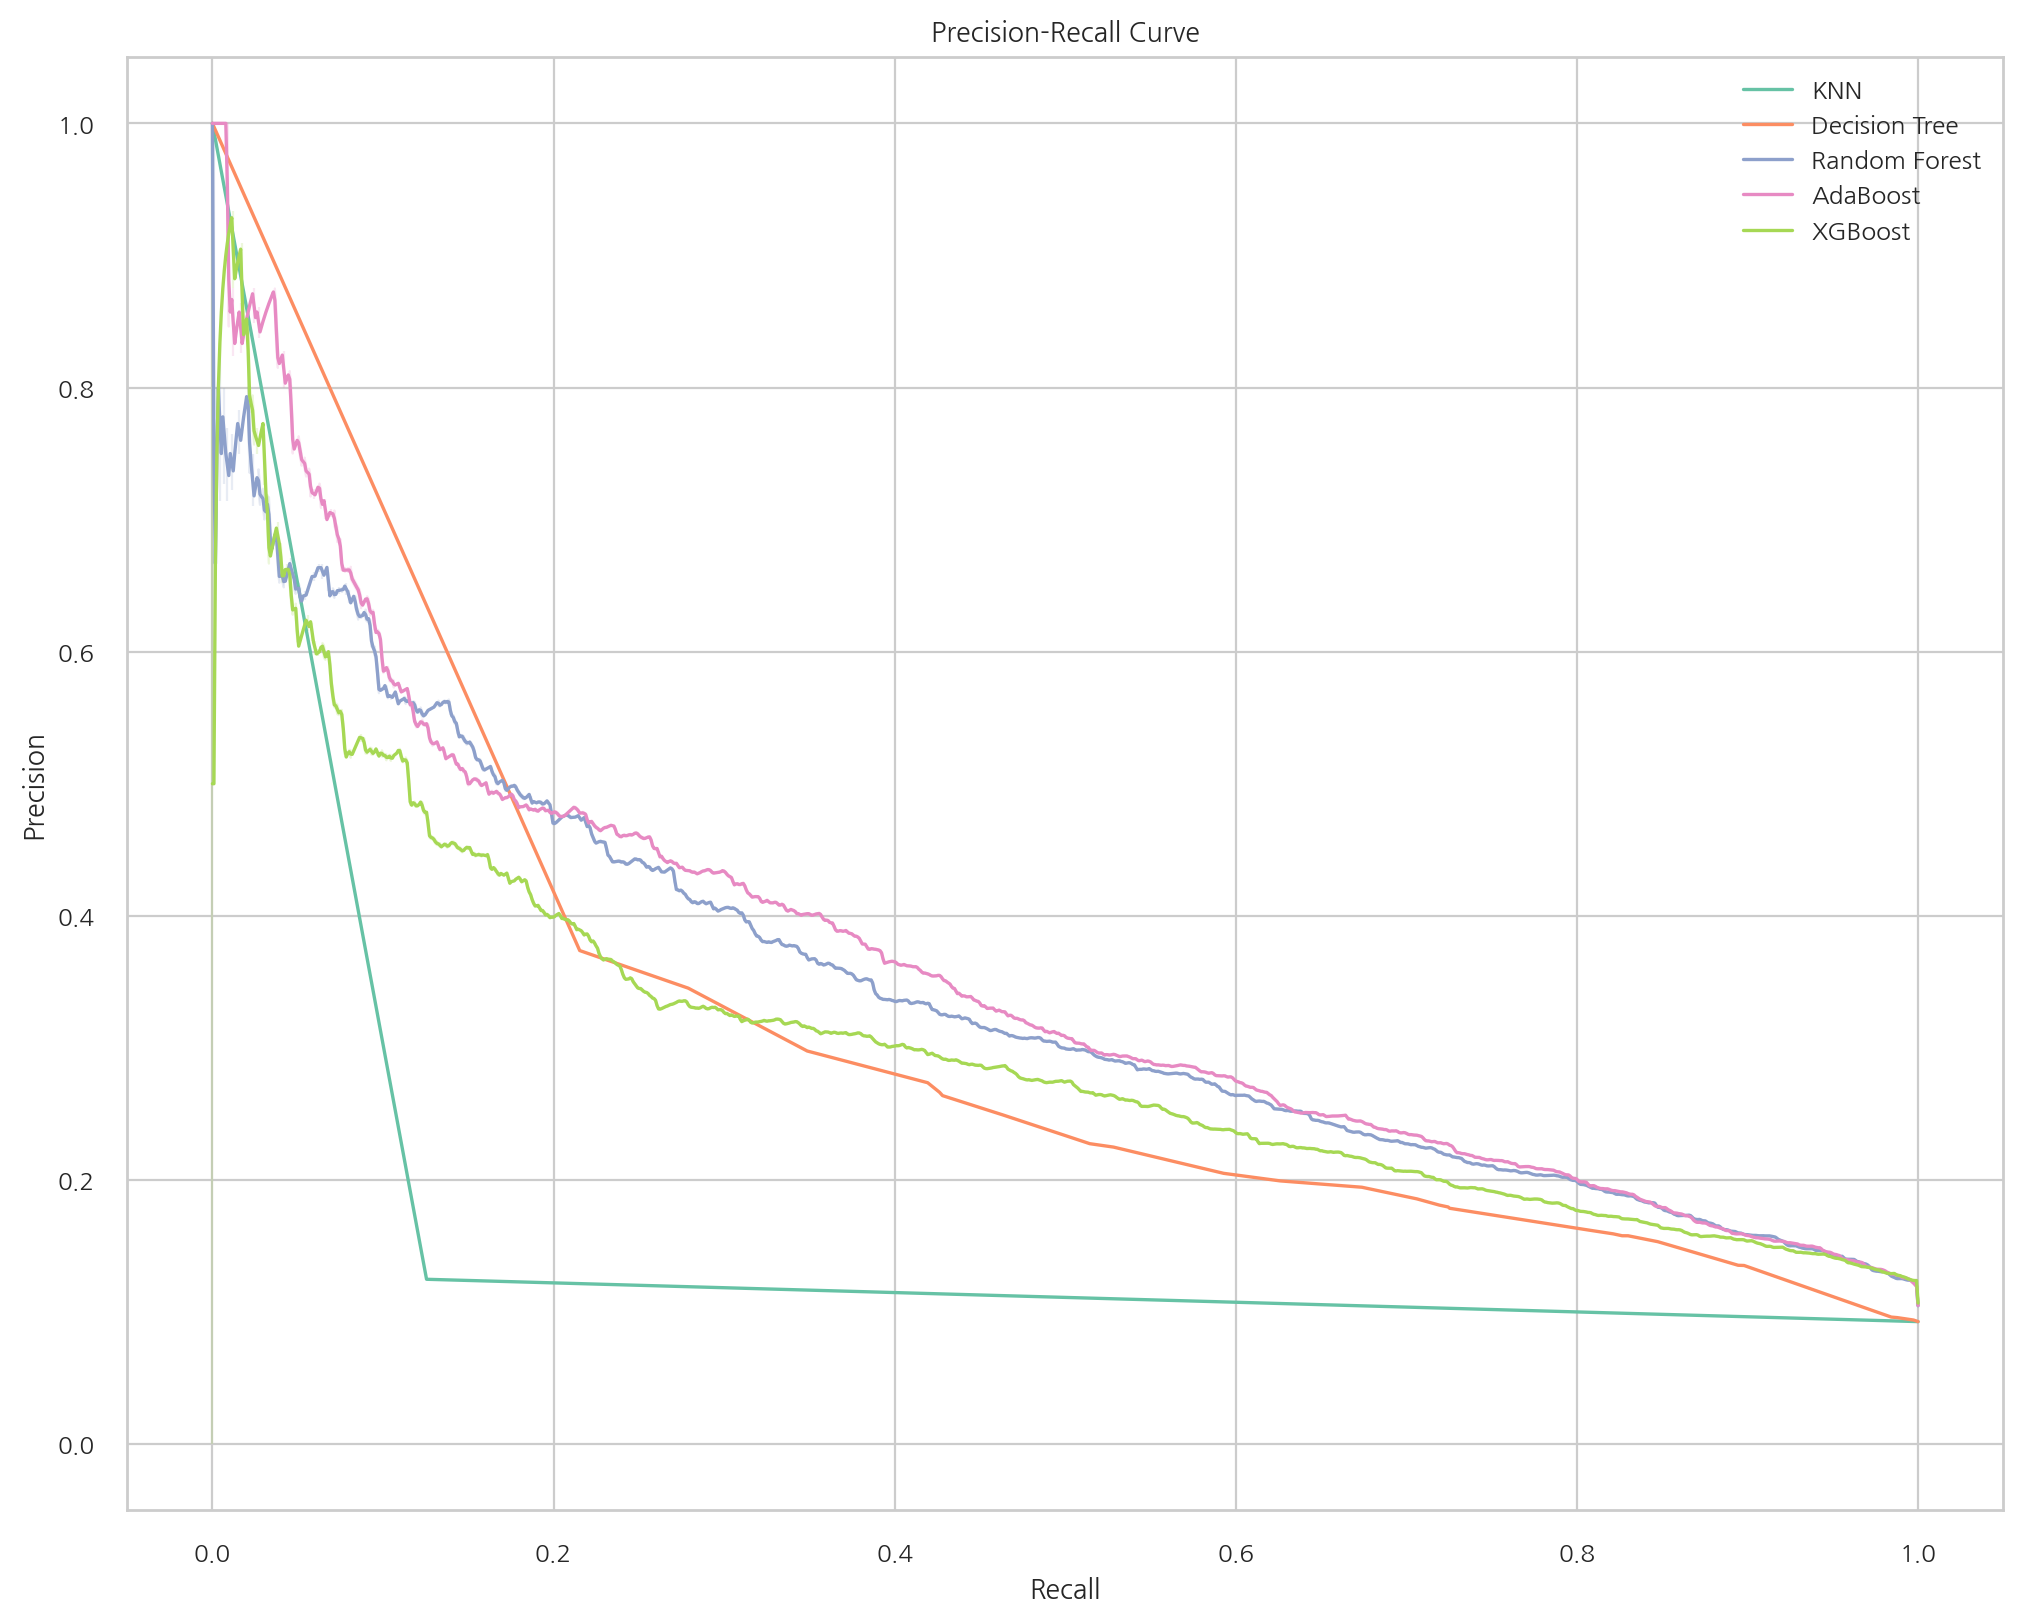

In [ ]:


# 각 모델에 대한 Precision-Recall 곡선 그리기
plt.figure(figsize=(6, 4))

curves = []
curves.append(plot_precision_recall_curve(test_y, knn_rs.predict_proba(test_x)[:,1], 'KNN'))
curves.append(plot_precision_recall_curve(test_y, dt_gs.predict_proba(test_x)[:,1], 'Decision Tree'))
curves.append(plot_precision_recall_curve(test_y, rf_rs.predict_proba(test_x)[:,1], 'Random Forest'))
curves.append(plot_precision_recall_curve(test_y, ad_rs.predict_proba(test_x)[:,1], 'AdaBoost'))
curves.append(plot_precision_recall_curve(test_y, xg_rs.predict_proba(test_x)[:,1], 'XGBoost'))

# 그래프 설정
fig, ax = plt.subplots(figsize=(10, 8))

for curve in curves:
    sns.lineplot(
        x=curve[0],
        y=curve[1],
        label=curve[2],
        ax=ax)

ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('개별 모델의 Precision-Recall Curve')
ax.legend()
ax.grid(True);

In [ ]:
model_dict

{'knn,decision Tree 스택': StackingClassifier(estimators=[('knn', KNeighborsClassifier(n_neighbors=1)),
                                ('decision Tree',
                                 DecisionTreeClassifier(max_depth=30,
                                                        max_features='sqrt',
                                                        max_leaf_nodes=30,
                                                        min_samples_leaf=5,
                                                        min_samples_split=5))],
                    final_estimator=LogisticRegression())}

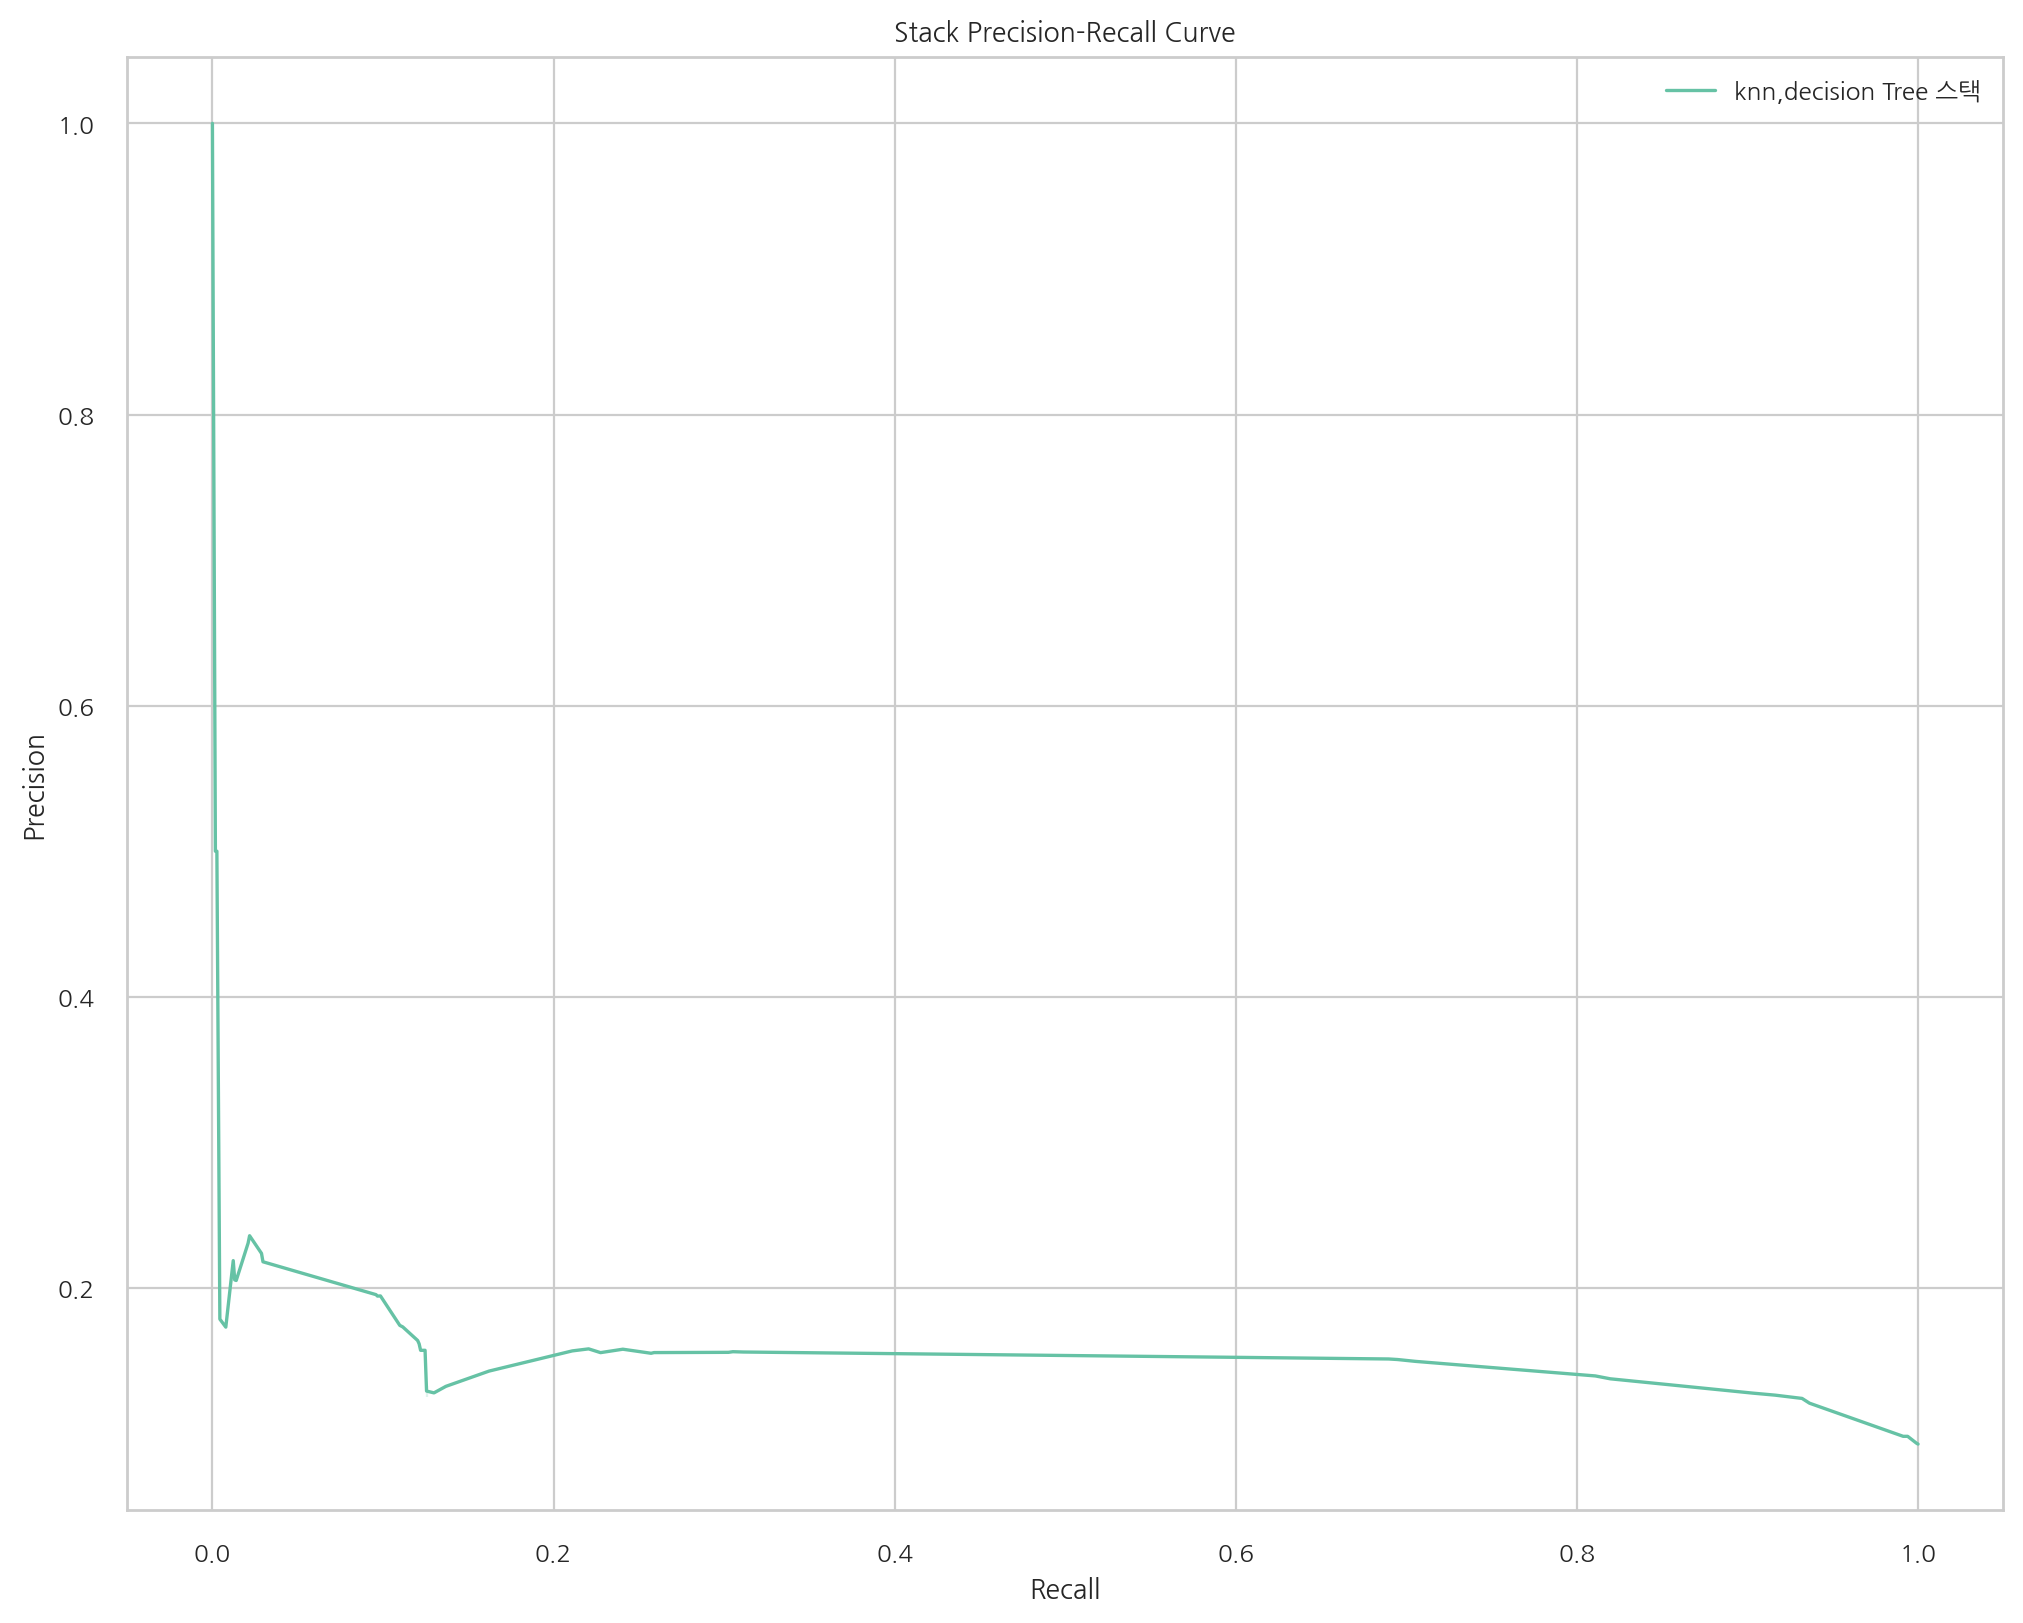

In [ ]:
curves_stacked = []

for i in range(len(model_dict)):
    name = list(model_dict.keys())[i]
    curves_stacked.append(plot_precision_recall_curve(test_y, model_dict[name].predict_proba(test_x)[:,1], name))

# 그래프 설정
fig, ax = plt.subplots(figsize=(10, 8))

for curve in curves_stacked:
    sns.lineplot(
        x=curve[0],
        y=curve[1],
        label=curve[2],
        ax=ax)

ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Stack Precision-Recall Curve')
ax.legend()
ax.grid(True);

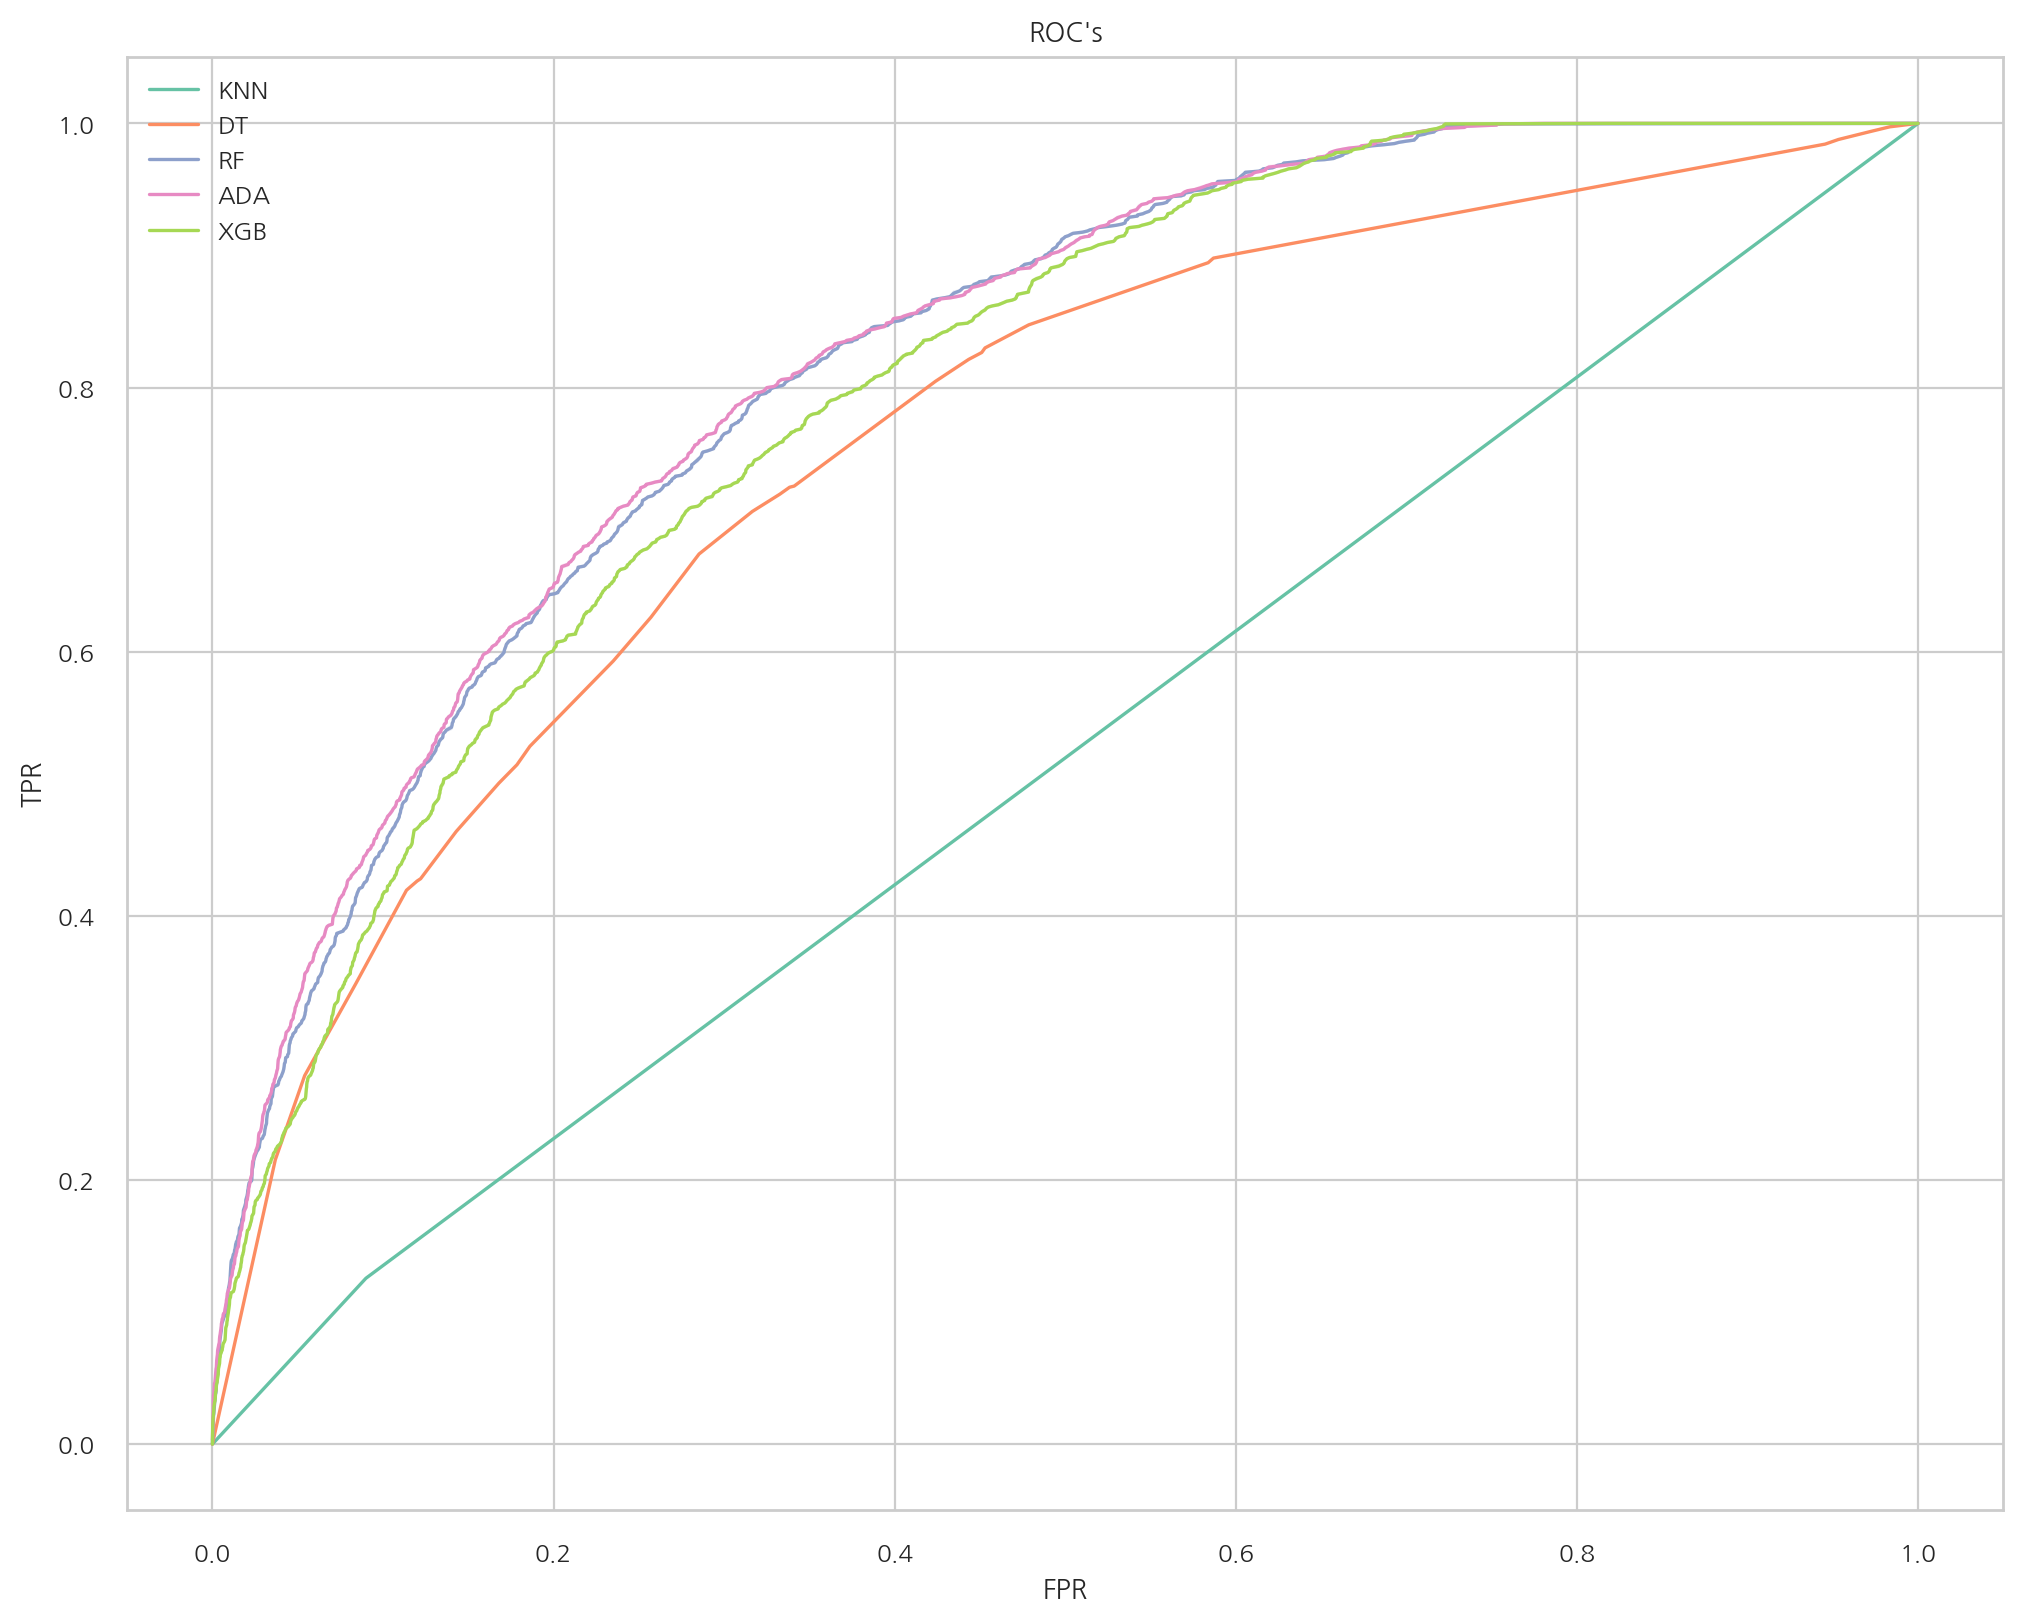

In [ ]:
# 이진 분류 일때만 사용 가능
models_best = [knn_rs, dt_gs, rf_rs, ad_rs, xg_rs]
names_models = ["KNN", "DT", "RF", "ADA", "XGB"]
roc_curves = {}


for name, model in zip(names_models, models_best):
    fpr, tpr, thr = roc_curve(test_y, model.predict_proba(test_x)[:,1])
    roc_curves[name] = (fpr, tpr)

In [ ]:
# 면적
print("테스트 데이터에 대한 roc _ auc 커브 면적")
print("dscision tree 면적",roc_auc_score(test_y, dt_gs.predict_proba(test_x)[:,1]))
print("KNN 면적",roc_auc_score(test_y, knn_rs.predict_proba(test_x)[:,1]))
print("랜덤 포레스트 면적",roc_auc_score(test_y, rf_rs.predict_proba(test_x)[:,1]))
print("ada boost 면적",roc_auc_score(test_y, ad_rs.predict_proba(test_x)[:,1]))
print("XG Boost 면적",roc_auc_score(test_y, xg_rs.predict_proba(test_x)[:,1]))

테스트 데이터에 대한 roc _ auc 커브 면적
dscision tree 면적 0.7562234221183441
KNN 면적 0.517775568464965
랜덤 포레스트 면적 0.8159408600208454
ada boost 면적 0.8198702362760619
XG Boost 면적 0.7968170591886867


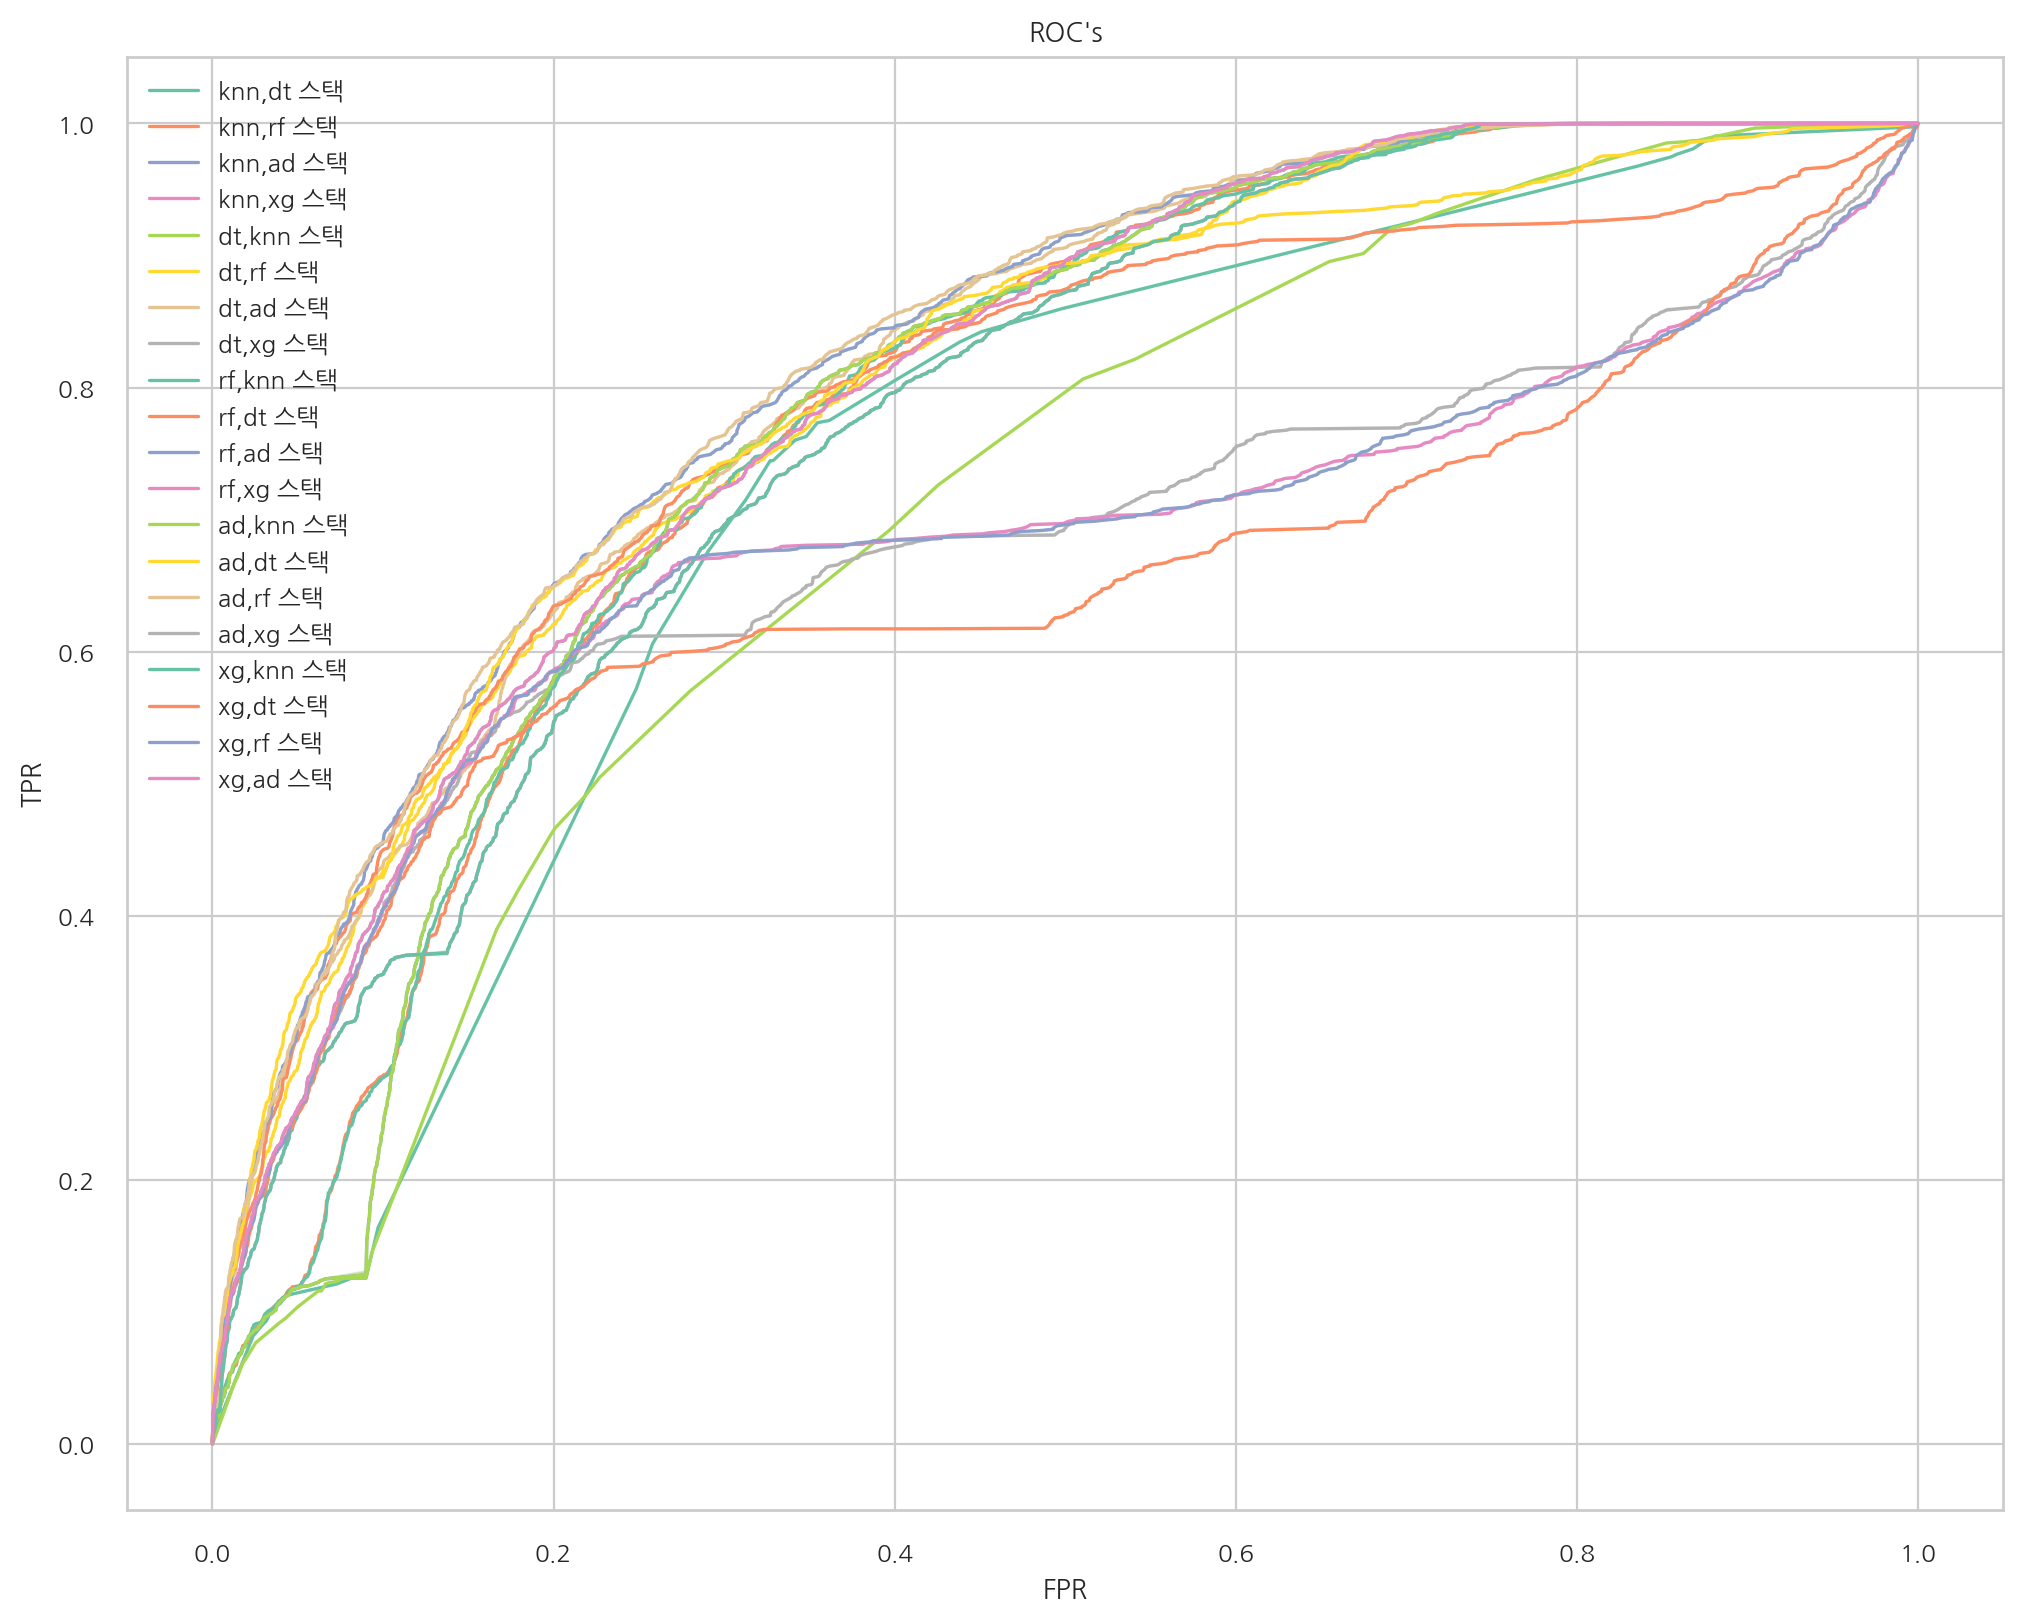

In [ ]:
# 스택 모델별 면적
roc_curves_for_stacked = {}

for i in range(len(model_dict)):
    name = list(model_dict.keys())[i]
    fpr, tpr, thr = roc_curve(test_y, model_dict[name].predict_proba(test_x)[:,1])
    roc_curves_for_stacked[name] = (fpr, tpr)

In [ ]:
# 면적
# 각 스택 모델별 면적
print("각 스택 모델별 면적 테스트 데이터에 대한 roc _ auc 커브 면적")
for i in range(len(list(model_dict.keys()))):
    print(f"{list(model_dict.keys())[i]}의 면적 : ",roc_auc_score(test_y, model_dict[list(model_dict.keys())[i]].predict_proba(test_x)[:,1]))

각 스택 모델별 면적 테스트 데이터에 대한 roc _ auc 커브 면적
knn,dt 스택의 면적 :  0.7273255483799499
knn,rf 스택의 면적 :  0.7770160931037356
knn,ad 스택의 면적 :  0.7771674589973994
knn,xg 스택의 면적 :  0.7729956331891299
dt,knn 스택의 면적 :  0.6992107610624309
dt,rf 스택의 면적 :  0.7888848571260553
dt,ad 스택의 면적 :  0.8069511941514426
dt,xg 스택의 면적 :  0.6762694867565914
rf,knn 스택의 면적 :  0.7771984934723895
rf,dt 스택의 면적 :  0.7789672643386072
rf,ad 스택의 면적 :  0.8154053890919142
rf,xg 스택의 면적 :  0.6757881610818983
ad,knn 스택의 면적 :  0.7771674589973994
ad,dt 스택의 면적 :  0.8077043336634097
ad,rf 스택의 면적 :  0.817153107786111
ad,xg 스택의 면적 :  0.7966990194271152
xg,knn 스택의 면적 :  0.7729956331891299
xg,dt 스택의 면적 :  0.6454250250975294
xg,rf 스택의 면적 :  0.675535146601189
xg,ad 스택의 면적 :  0.7966990194271152


### DNN 으로 모델 돌려보기

In [ ]:
import random
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

import pandas as pd
from sklearn.preprocessing import StandardScaler

# 표준 편차로 정규화
scaler = StandardScaler()
df_scaled = scaler.fit_transform(x_ros)

#텐서로 변환
x_ros_tensor = tf.convert_to_tensor(df_scaled, dtype=tf.float32)
y_ros_tensor = tf.convert_to_tensor(y_ros, dtype=tf.float32)

random.seed(42)

#입력노드 수 = feature 수
input_node = 13
#출력노드 수
output_node = 1

#모델
dnn = Sequential(name = "horse_classifier")
dnn.add(Dense(256,
              kernel_initializer='he_normal',
              activation = "relu",
              input_shape=(input_node,)
             ))
dnn.add(Dropout(0.3))
dnn.add(Dense(128,
              kernel_initializer='he_normal',
              activation = "relu",
             ))
dnn.add(Dropout(0.3))
dnn.add(Dense(64,
              kernel_initializer='he_normal',
              activation = "relu",
             ))
dnn.add(Dropout(0.3))
dnn.add(Dense(32,
              kernel_initializer='he_normal',
              activation = "relu",
             ))
dnn.add(Dropout(0.3))
dnn.add(Dense(1,
              kernel_initializer='he_normal',
              activation = "sigmoid",
             ))

adam = Adam(learning_rate=0.001)

dnn.compile(loss='binary_crossentropy',
            optimizer=adam,
            metrics = ['accuracy'])

#validation loss가 연속 3번 감소하지 않으면 조기종료
early_stopping = EarlyStopping(patience = 3,
                               restore_best_weights=True)

dnn_hist = dnn.fit(x_ros_tensor,
                   y_ros_tensor,
                   epochs=2,
                   batch_size=302,
                   validation_split=0.2,
                   callbacks=[early_stopping],
                   verbose = 1
                  )

Epoch 1/2
238/238 [==============================] - 4s 7ms/step - loss: 0.6090 - accuracy: 0.6814 - val_loss: 0.7357 - val_accuracy: 0.5291
Epoch 2/2
238/238 [==============================] - 1s 6ms/step - loss: 0.5375 - accuracy: 0.7293 - val_loss: 0.6876 - val_accuracy: 0.6179


In [ ]:
dnn.evaluate(tf.convert_to_tensor(test_x, dtype=tf.float32), tf.convert_to_tensor(test_y, dtype=tf.float32))

387/387 [==============================] - 1s 3ms/step - loss: 1.1183 - accuracy: 0.9073


[1.1182905435562134, 0.9072756767272949]

In [ ]:
pred_dnn = dnn.predict(tf.convert_to_tensor(test_x, dtype=tf.float32))
pred_dnn = (pred_dnn > 0.5).astype(int)
pred_dnn

387/387 [==============================] - 1s 2ms/step


array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [ ]:
pred_dnn.sum()

0

In [ ]:
test_y.sum() / len(test_y)

0.09272433306386418

In [ ]:
print("정확도",metrics.accuracy_score(pred_dnn, test_y))
print("confusion_matrix",confusion_matrix(test_y, pred_dnn))
print("classification_report")
print(classification_report(test_y, pred_dnn))

정확도 0.9072756669361358
confusion_matrix [[11223     0]
 [ 1147     0]]
classification_report
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     11223
           1       0.00      0.00      0.00      1147

    accuracy                           0.91     12370
   macro avg       0.45      0.50      0.48     12370
weighted avg       0.82      0.91      0.86     12370



c:\Users\crazy\miniconda3\envs\kdt\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\crazy\miniconda3\envs\kdt\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\crazy\miniconda3\envs\kdt\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
